## Parameters for Figure 4.1 (Izhikevich):
+ C = 1, 
+ I = 0, 
+ EL = −80 mV, 
+ gL = 8, 
+ gNa = 20, 
+ gK = 10, 
+ m∞(V): V1/2 = −20 and k = 15, 
+ n∞(V) has V1/2 = −25 and k = 5, 
+ τ (V ) = 1, 
+ ENa = 60 mV, 
+ and EK = −90 mV. 

*Parameters in (b) as in (a) except EL = −78 mV and n∞(V ) has V1/2 = −45*

In [14]:
#@title FUNctions

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.optimize as opt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

def resetting_parameters():
    """ 
    Resetting the values to Fig 4.1a Parameters
    """
    pars = {'Cm' : 1.,
            'gl' : 8.,
            'El' : -80., # -78 (Fig 4.1b)
            'gna' : 20.,
            'Ena' : 60.,
            'gk' : 10.,
            'Ek' : -90.,
            'V12_m' : -20.,
            'V12_n' : -25., # -45 (Fig 4.1b)
            'k_m' : 15.,
            'k_n' : 5.,
            'tau' : 0.152 # 1.
            }
    return pars

def InapIk_DEs(variables, pars, I = 0.):
  """ 
  Differential equations 
  """
  m_inf = 1/(1 + np.exp((pars['V12_m'] - variables[0])/pars['k_m']))
  n_inf = 1/(1 + np.exp((pars['V12_n'] - variables[0])/pars['k_n']))
  
  V = (1/pars['Cm']) * (I - pars['gl'] * (variables[0] - pars['El']) - 
                        pars['gna'] * m_inf * #variables[1] * 
                        (variables[0] - pars['Ena']) - 
                        pars['gk'] * variables[2] * 
                        (variables[0] - pars['Ek']))
  
  m = 0.#(m_inf - variables[1])/pars['tau']
  n = (n_inf - variables[2])/pars['tau']

  q=np.array([V,m,n])
  return q

def fhn_DEs(variables, pars, I = 10.0):
    """ 
    FitzHugh-Nagumo differential equations 
    """
    
    oneoverepsilon = 100.0 
    zeta = 0.9
    q1 = oneoverepsilon*(variables[0]*(1-variables[0]*variables[0]/3.) - variables[1] + I)
    q2 = variables[0] + zeta 
    q=np.array([q1,q2])
    return q

def fhn_DE(variables, pars, I = 10.0):
    """ 
    FitzHugh-Nagumo differential equations 
    """

    a = 0.7
    b = 0.8
    c = 0.08

    q1 = variables[0] - variables[0]**3 / 3 - variables[1] + I
    q2 = c * (variables[0] +a - b * variables[1])
    q=np.array([q1,q2])

    return q

def HH_DEs(variables, pars, I = 0):
    """ 
    Hodgkin-Huxley differential equations 
    """

    gk = 36.
    gna = 120.
    gl = .3
    Ek = -12.
    Ena = 115.
    El = 10.613
    Cm = 1.
    
    alpha_m = 0.1 * (25 - variables[0]) / (np.exp((25 - variables[0]) / 10) - 1)
    beta_m = 4 * np.exp(-variables[0] / 18)
    alpha_n = 0.01 * (10 - variables[0]) / (np.exp((10 - variables[0])  /10) - 1)
    beta_n = 0.125 * np.exp(-variables[0] / 80)
    alpha_h = 0.07 * np.exp(-variables[0] / 20)
    beta_h = 1 / (np.exp(3 - variables[0] / 10) + 1)
    
    V = (1/Cm) * (gk * variables[3]**4 * (Ek - variables[0]) + gna * 
                  variables[1]**3 * variables[2] * 
                  (Ena - variables[0])+ gl * 
                  (El - variables[0]) + I)
    
    m = alpha_m * (1 - variables[1]) - beta_m * variables[1]
    h = alpha_h * (1 - variables[2]) - beta_h * variables[2]
    n = alpha_n * (1 - variables[3]) - beta_n * variables[3]
    
    q=np.array([V, m, h, n])
    return q

def rk4(ODE, variables, pars, current, tempo, deltat):
    
    dim = len(variables)
    
    k1 = np.zeros([1,dim])
    k2 = np.zeros([1,dim])
    k3 = np.zeros([1,dim])
    k4 = np.zeros([1,dim])
    
    deri = ODE(variables, pars, I = current)
    k1 = deltat*deri
    aux = 0.5*k1 + variables

    deri = ODE(aux, pars, I = current)
    k2 = deltat*deri
    aux = k2*0.5+ variables
    
    deri = ODE(aux, pars, I = current)
    k3 = deltat*deri
    aux = k3+variables
    
    deri = ODE(aux, pars, I = current)
    k4 = deltat*deri
    
    variables_novas = variables + (k1+2*k2+2*k3+k4)/6.0

    return variables_novas

def simulate(ODE, current, pars, dt, t, x0):

    steps = round(t / dt)
    
    x = np.zeros([steps+1,len(x0)])
    x[0] = x0
    
    xold = np.array(x[0])
    xnew = np.array(x[0])
    
    for i in range(steps+1):
        xnew[:] = rk4(ODE, xold, pars, current[i], t, dt)
        x[i,:] = xnew
        xold[:] = xnew
    
    return x

def get_nullclines(V, I, m_inf, pars):

    n_V = (I - pars['gl'] * (V - pars['El']) - pars['gna'] * m_inf * (V - pars['Ena'])) / (pars['gk'] * (V - pars['Ek']))
    n_n = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))
    
    return n_V, n_n

def InapIk_DE(V, n, pars, I = 0.):
  
  m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))
  n_inf = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

  V = (1/pars['Cm']) * (I - pars['gl'] * (V - pars['El']) - 
                        pars['gna'] * m_inf * 
                        (V - pars['Ena']) - 
                        pars['gk'] * n * 
                        (V - pars['Ek']))
  
  #m = (m_inf - variables[1])/pars['tau']
  n = (n_inf - n)/pars['tau']

  #q=np.array([V, n])
  return V, n

def my_fp(pars, I, rE_init, rI_init):
  """
  Use opt.root function to solve DEs
  """

  def my_DEr(x):
    """
    Defines the right hand of differential equations
    """
    V, n = x

    m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))
    n_inf = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

    dV = (1/pars['Cm']) * (I - pars['gl'] * (V - pars['El']) - 
                          pars['gna'] * m_inf * 
                          (V - pars['Ena']) - 
                          pars['gk'] * n * 
                          (V - pars['Ek']))
    dn = (n_inf - n)/pars['tau']
    
    y = np.array([dV, dn])

    return y

  x0 = np.array([rE_init, rI_init])
  x_fp = opt.root(my_DEr, x0).x

  return x_fp

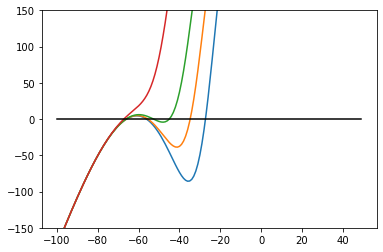

In [15]:
#@title Reproducing Fig. 4.1 from Dynamical system in Neuroscience, Izhikevich (Analitic)

pars = resetting_parameters()

fig, axis1 = plt.subplots(1,1)

V = np.arange(-100, 50)

m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))
n_inf = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

I = pars['gl'] * (V - pars['El']) + pars['gna'] * m_inf * (V - pars['Ena']) + pars['gk'] * n_inf * (V - pars['Ek'])

plt.ylim(bottom = -150, top = 150)
axis1.plot(V, I, '-')

pars['V12_n'] = -30.
pars['El'] = -80.

V = np.arange(-100, 50)

m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))
n_inf = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

I = pars['gl'] * (V - pars['El']) + pars['gna'] * m_inf * (V - pars['Ena']) + pars['gk'] * n_inf * (V - pars['Ek'])

plt.ylim(bottom = -150, top = 150)
axis1.plot(V, I, '-')

pars['V12_n'] = -35.
pars['El'] = -80.

V = np.arange(-100, 50)

m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))
n_inf = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

I = pars['gl'] * (V - pars['El']) + pars['gna'] * m_inf * (V - pars['Ena']) + pars['gk'] * n_inf * (V - pars['Ek'])

plt.ylim(bottom = -150, top = 150)
axis1.plot(V, I, '-')

pars['V12_n'] = -45.
pars['El'] = -80.

V = np.arange(-100, 50)

m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))
n_inf = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

I = pars['gl'] * (V - pars['El']) + pars['gna'] * m_inf * (V - pars['Ena']) + pars['gk'] * n_inf * (V - pars['Ek'])

plt.ylim(bottom = -150, top = 150)
axis1.plot(V, I, '-')

axis1.plot(V, 0 * V, 'k-')
plt.show()


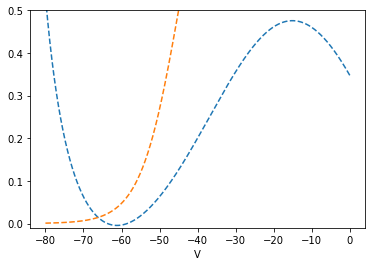

In [16]:
#@title Nullclines

V = np.arange(-80, 0, 0.01)

m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

I = 3 + 0 * V

n_V = (I - pars['gl'] * (V - pars['El']) - pars['gna'] * m_inf * (V - pars['Ena'])) / (pars['gk'] * (V - pars['Ek']))
n_N = 1/(1 + np.exp((pars['V12_n'] - V)/pars['k_n']))

plt.ylim(top = 0.5, bottom = -0.01)
plt.plot(V, n_V, '--')
plt.plot(V, n_N, '--')
plt.xlabel('V')
plt.show()


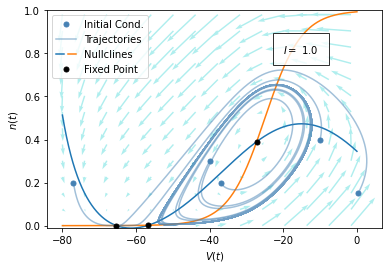

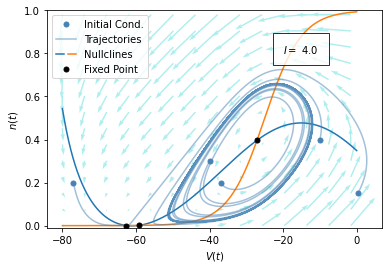

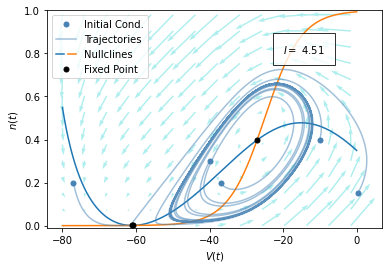

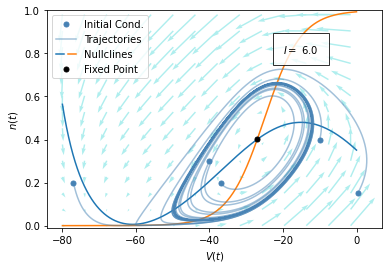

In [17]:
#@title Saddle-node in the Phase Space
#@markdown - Two fixed points colliding and disappearing
#@markdown - The trajectories show the emergence of a limit-cycle
#@markdown - We observe the ghost of the saddle-node after the bifurcation in the vector-field.

pars = resetting_parameters()

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

Is = [1., 4., 4.51, 6.]

for I in Is:
  
    current = np.ones(1+round(tempo / dt))* I

    n_V, n_n = get_nullclines(V, I, m_inf, pars)

    null1, = plt.plot(V, n_V, '-', color = 'tab:blue')
    null2, = plt.plot(V, n_n, '-', color = 'tab:orange')

    grid1 = np.linspace(-80., 0., 200)
    grid0 = np.linspace(0., 1., 200)
    grid_v, grid_n = np.meshgrid(grid1, grid0)
    dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)

    n_skip = 15
    plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
                dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
                angles='xy', scale_units='xy', scale=50., facecolor='paleturquoise')

    x_inits = [[.32, m_inf[0], .15], [-10., m_inf[0], .4], \
                [-40., m_inf[0], .3], [-77., m_inf[0], .2], \
                [-37., m_inf[0], .2]]

    for x_init in x_inits:
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
        B, = plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)#, label=mylabel)
        A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)
    if I < 5:
        inits = [[-79.9, 0.001], [-57.9, 0.001], [-25.9, 0.5]]
    else:
        inits = [[-25.9, 0.5]]
    for init in inits:
        fp = my_fp(pars, I, init[0], init[1])
        fps, = plt.plot(fp[0], fp[1], 'o', color='black', ms=5)

    plt.text(-20, 0.8, r'$I =$ {}'.format(I), #style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

    plt.legend([A, B, (null1, null2), fps], ['Initial Cond.', \
                                            'Trajectories', 'Nullclines', 'Fixed Point'], \
                numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    plt.ylabel(r'$n(t)$')
    plt.xlabel(r'$V(t)$')
    plt.ylim(top = 1., bottom = -0.01)
    plt.show()


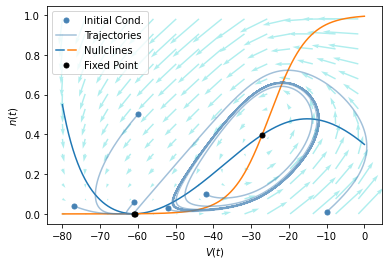

In [18]:
#@title The saddle-node moment

pars = resetting_parameters()

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

I = 4.51 #+ 0 * V

current = np.ones(1+round(tempo / dt))* I

n_V, n_n = get_nullclines(V, I, m_inf, pars)

null1, = plt.plot(V, n_V, '-', color = 'tab:blue')
null2, = plt.plot(V, n_n, '-', color = 'tab:orange')

grid_ = np.linspace(-80., 0., 200)
grid_1 = np.linspace(0., 1., 200)
grid_v, grid_n = np.meshgrid(grid_, grid_1)
dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)

n_skip = 15
plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
            dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
            angles='xy', scale_units='xy', scale=50., facecolor='paleturquoise')

x_inits = [[-60., m_inf[0], .5],[-61., m_inf[0], .06], [-10., m_inf[0], .01], \
            [-42., m_inf[0], .1], [-77., m_inf[0], .04], [-52., m_inf[0], .03]]

for x_init in x_inits:
    q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
    B, =plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)#, label=mylabel)
    A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)
plt.legend([A,B], ['C', 'T'])
inits = [[-79.9, 0.001], [-57.9, 0.001], [-25.9, 0.5]]

for init in inits:
    fp = my_fp(pars, I, init[0], init[1])
    fps, = plt.plot(fp[0], fp[1], 'o', color='black', ms=5)


plt.legend([A, B, (null1, null2), fps], ['Initial Cond.', 'Trajectories', \
                                            'Nullclines', 'Fixed Point'], \
            numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
plt.ylabel(r'$n(t)$')
plt.xlabel(r'$V(t)$')
#plt.savefig('saddlenode_zoomout')
plt.show()


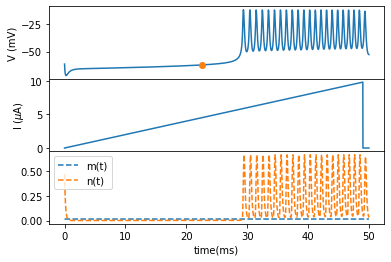

In [19]:
#@title Saddle-node Example
#@markdown - We observe a delay in oscilation because of the saddle-node ghost

fig, (axis1,axis2, axis3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=0)

pars = resetting_parameters()

dt = 0.01
tempo = 50

t_trans = 50
t = dt*np.arange(1+round(tempo/dt))
step = 0.002

current = np.zeros(1+round(tempo / dt))

for i in range(len(current[:-round(1/dt)])):
    current[i] +=  i*step

cond_init = [-60.]
n_init = [0.5]
for V0 in cond_init:
  for n0 in n_init:

    m0 = .015

    init = [V0, m0, n0]

    q=simulate(InapIk_DEs, current, pars, dt, tempo, init)

# with plt.xkcd():
    axis1.plot(t, q[:,0],'-')
    axis1.plot(t[current >= 4.51][0], q[current >= 4.51,0][0],'o')
    axis1.set_ylabel('V (mV)')

    axis2.plot(t,current)
    axis2.set_ylabel(r'I ($\mu$A)')

    axis3.plot(t,q[:,1],'--', label = "m(t)")
    axis3.plot(t,q[:,2],'--', label = "n(t)")
    axis3.set_xlabel('time(ms)')
    axis3.legend()

plt.show()

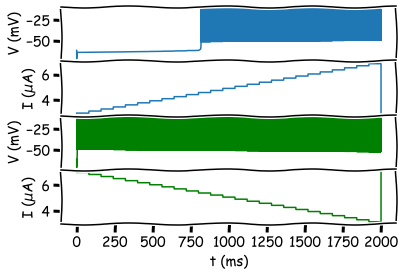

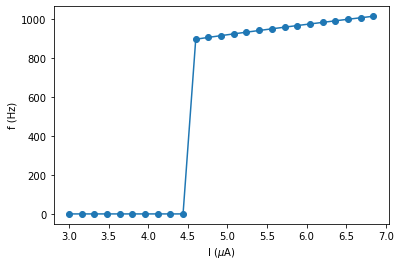

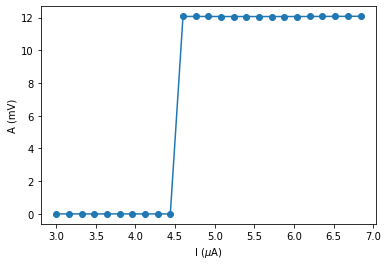

In [20]:
#@title Saddle-node Frequency
#@markdown - The frequency and amplitude are discontinuous with
#@markdown respect to the current and are not zero at the bifurcation.

pars = resetting_parameters()

cor = []
freq = []

with plt.xkcd():
  fig, ax = plt.subplots(4,1)#, sharex=True)
  fig.subplots_adjust(hspace=0)

dt=0.01
tempo= 2000

st = 80
current_inicial = 3
current_final = 7
step = (current_final - current_inicial)/(tempo // st)

current1 = np.ones(1+round(tempo / dt)) * current_inicial

i = 0
for j in range(tempo//st):
    current1[round(i/dt):round((i+st)/dt)] += (i / st) * step
    i += st

current2 = np.zeros(1+round(tempo / dt))

current2[:] = current_final

i = 0
for j in range(tempo//st):
    current2[round(i/dt):round((i+st)/dt)] -= (i / st) * step
    cor.append((i / st) * step + current_inicial)
    i += st

V0 = -60.
m0 = 0.0
n0 = .5

init = [V0, m0, n0]

q1=simulate(InapIk_DEs, current1, pars, dt, tempo, init)
q2=simulate(InapIk_DEs, current2, pars, dt, tempo, init)

t=dt*np.arange(1+round(tempo/dt))

# with plt.xkcd():    
ax[0].plot(t,q1[:,0],'-')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t,current1)
ax[1].set_ylabel(r'I ($\mu$A)')

ax[2].plot(t,q2[:,0],'g-')
ax[2].set_ylabel('V (mV)')

ax[3].plot(t,current2, 'g-')
ax[3].set_ylabel(r'I ($\mu$A)')
ax[3].set_xlabel('t (ms)')

freq1 = []
freq2 = []
amp1 = []
amp2 = []

i = 0
for j in range(tempo//st):
    qsliced1 = q1[round(i/dt):round((i+st)/dt)]
    qsliced2 = q2[round(i/dt):round((i+st)/dt)]
    csl1 = (np.diff(np.sign(np.diff(qsliced1[:,0]))) < 0).nonzero()[0] + 1 
        # local max
    csl2 = (np.diff(np.sign(np.diff(qsliced2[:,0]))) < 0).nonzero()[0] + 1 
    t_peaks = []
    amp_peaks = []
    if len(csl1) > 2:
      for j in csl1:
        if qsliced1[j,0] > -50.0:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced1[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq1.append(freq_aux)
        amp1.append(np.abs(np.mean(amp_peaks)))
      else:
        freq1.append(0)
        amp1.append(0)
    else:
      freq1.append(0)
      amp1.append(0)
    t_peaks = []
    amp_peaks = []
    if len(csl2) > 3:
      for j in csl2:
        if qsliced2[j,0] > -50.0:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced2[j,0])
      if (len(t_peaks) > 3):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq2.append(freq_aux)
        amp2.append(np.abs(np.mean(amp_peaks)))
      else:
        freq2.append(0)
        amp2.append(0)
    else:
      freq2.append(0)
      amp2.append(0)
    i += st

plt.show()

plt.ylabel('f (Hz)')
plt.xlabel(r'I ($\mu$A)')
plt.plot(cor,freq1,'o-')
plt.show()
plt.plot(cor,amp1,'o-')
plt.ylabel('A (mV)')
plt.xlabel(r'I ($\mu$A)')
#plt.savefig('histereseex9')
plt.show()

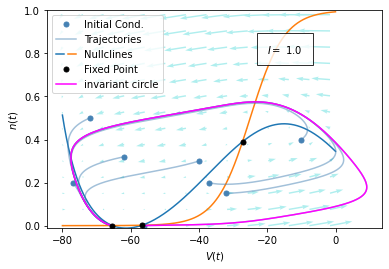

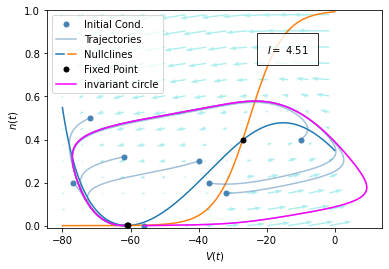

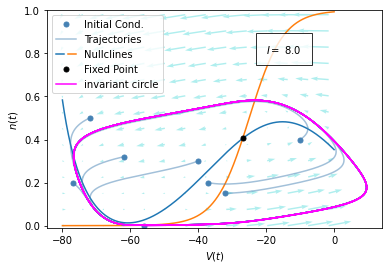

In [21]:
#@title Saddle-node and Invariant cycle in the Phase Space
#@markdown - Saddle-node
#@markdown - The limit-cycle is now an invariant cycle that contains the fixed points.
#@markdown - The ghost shows stronger delay.

pars = resetting_parameters()

pars['tau'] = 1.

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

Is = [1., 4.51, 8.]

for I in Is:
    current = np.ones(1+round(tempo / dt))* I

    n_V, n_n = get_nullclines(V, I, m_inf, pars)

    null1, = plt.plot(V, n_V, '-', color = 'tab:blue')
    null2, = plt.plot(V, n_n, '-', color = 'tab:orange')

    grid_ = np.linspace(-80., 0., 200)
    grid_1 = np.linspace(0., 1., 200)
    grid_v, grid_n = np.meshgrid(grid_, grid_1)
    dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)
    # dVdt = DEs[0]
    # dndt = DEs[1]
    #print(dVdt)
    n_skip = 15
    plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
                dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
                angles='xy', scale_units='xy', scale=50., facecolor='paleturquoise')

    x_inits = [[-72, m_inf[0], .5], [-62, m_inf[0], .32], [-32., m_inf[0], .15], \
                [-56, m_inf[0], 0.], [-10., m_inf[0], .4], [-40., m_inf[0], .3], \
                    [-77., m_inf[0], .2], [-37., m_inf[0], .2]]

    for x_init in x_inits:
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
        B, = plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)
        A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)
     
    x_i = [-56, m_inf[0], 0.]
    q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
    ciclo, = plt.plot(q[:,0], q[:,2], color='magenta')
    
    if I > 4.51:
        inits = [[-25.9, 0.5]]
    else:
        inits = [[-79.9, 0.001], [-57.9, 0.001], [-25.9, 0.5]]
    for init in inits:
        fp = my_fp(pars, I, init[0], init[1])
        fps, = plt.plot(fp[0], fp[1], 'o', color='black', ms=5)
    plt.text(-20, 0.8, r'$I =$ {}'.format(I), #style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.legend([A, B, (null1, null2), fps, ciclo], \
                ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point', 'invariant circle'], \
                    numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    plt.ylabel(r'$n(t)$')
    plt.xlabel(r'$V(t)$')
    plt.ylim(top = 1., bottom = -0.01)
    plt.show()


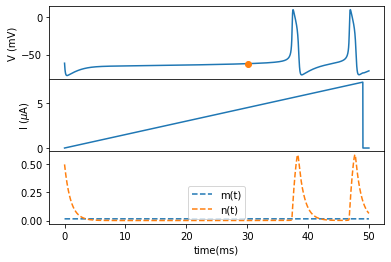

In [22]:
#@title Saddle-node and Invariant cycle Example
#@markdown - Oscillations emerge after bifurcation.
#@markdown - Between spikes, the ghost saddle-node causes a *tant* structure.

# with plt.xkcd():
fig, (axis1,axis2, axis3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=0)

pars = resetting_parameters()

pars['tau'] = 1.

dt = 0.01
tempo = 50

t_trans = 50
t = dt*np.arange(1+round(tempo/dt))
# t_ef = t[round(t_trans / dt):]
step = 0.0015

current = np.zeros(1+round(tempo / dt))

for i in range(len(current[:-round(1/dt)])):
    current[i] +=  i*step

cond_init = [-60.]
n_init = [0.5]
for V0 in cond_init:
  for n0 in n_init:

    m0 = .015

    init = [V0, m0, n0]

    q=simulate(InapIk_DEs, current, pars, dt, tempo, init)


# with plt.xkcd():
    axis1.plot(t, q[:,0],'-')
    axis1.plot(t[current >= 4.51][0], q[current >= 4.51,0][0],'o')
    axis1.set_ylabel('V (mV)')

    axis2.plot(t,current)
    axis2.set_ylabel(r'I ($\mu$A)')

    axis3.plot(t,q[:,1],'--', label = "m(t)")
    axis3.plot(t,q[:,2],'--', label = "n(t)")
    axis3.set_xlabel('time(ms)')
    axis3.legend()

plt.show()

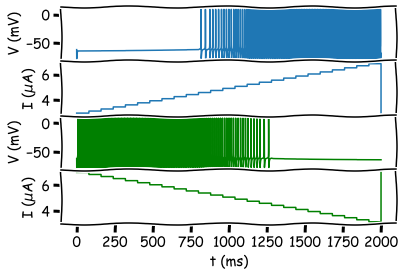

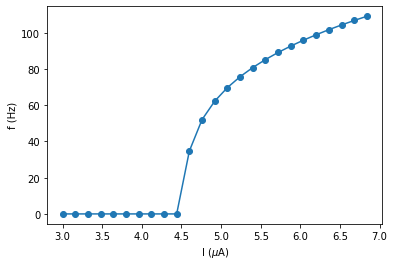

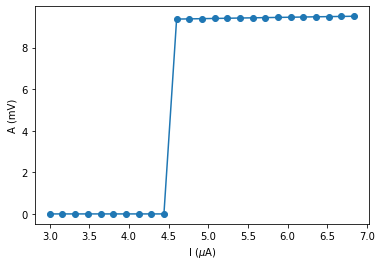

In [23]:
#@title Frequency in the Saddle-node and Invariant cycle
#@markdown - Continous Frequency, I-Ib -> 0, freq -> 0
#@markdown - The amplitude, however, is discontinuous.

pars = resetting_parameters()

pars['tau'] = 1.

cor = []
freq = []

with plt.xkcd():
  fig, ax = plt.subplots(4,1)
  fig.subplots_adjust(hspace=0)

dt=0.01
tempo= 2000

st = 80
current_inicial = 3
current_final = 7
step = (current_final - current_inicial)/(tempo // st)

current1 = np.ones(1+round(tempo / dt)) * current_inicial

i = 0
for j in range(tempo//st):
    current1[round(i/dt):round((i+st)/dt)] += (i / st) * step
    i += st

current2 = np.zeros(1+round(tempo / dt))

current2[:] = current_final

i = 0
for j in range(tempo//st):
    current2[round(i/dt):round((i+st)/dt)] -= (i / st) * step
    cor.append((i / st) * step + current_inicial)
    i += st

V0 = -60.
m0 = 0.0
n0 = .5

init = [V0, m0, n0]

q1=simulate(InapIk_DEs, current1, pars, dt, tempo, init)
q2=simulate(InapIk_DEs, current2, pars, dt, tempo, init)

t=dt*np.arange(1+round(tempo/dt))

# with plt.xkcd():    
ax[0].plot(t,q1[:,0],'-')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t,current1)
ax[1].set_ylabel(r'I ($\mu$A)')

ax[2].plot(t,q2[:,0],'g-')
ax[2].set_ylabel('V (mV)')

ax[3].plot(t,current2, 'g-')
ax[3].set_ylabel(r'I ($\mu$A)')
ax[3].set_xlabel('t (ms)')

freq1 = []
freq2 = []
amp1 = []
amp2 = []

i = 0
for j in range(tempo//st):
    qsliced1 = q1[round(i/dt):round((i+st)/dt)]
    qsliced2 = q2[round(i/dt):round((i+st)/dt)]
    csl1 = (np.diff(np.sign(np.diff(qsliced1[:,0]))) < 0).nonzero()[0] + 1 
        # local max
    csl2 = (np.diff(np.sign(np.diff(qsliced2[:,0]))) < 0).nonzero()[0] + 1 
    t_peaks = []
    amp_peaks = []
    if len(csl1) > 2:
      for j in csl1:
        if qsliced1[j,0] > -50.0:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced1[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq1.append(freq_aux)
        amp1.append(np.abs(np.mean(amp_peaks)))
      else:
        freq1.append(0)
        amp1.append(0)
    else:
      freq1.append(0)
      amp1.append(0)
    t_peaks = []
    amp_peaks = []
    if len(csl2) > 3:
      for j in csl2:
        if qsliced2[j,0] > -50.0:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced2[j,0])
      if (len(t_peaks) > 3):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq2.append(freq_aux)
        amp2.append(np.abs(np.mean(amp_peaks)))
      else:
        freq2.append(0)
        amp2.append(0)
    else:
      freq2.append(0)
      amp2.append(0)
    i += st

plt.show()

plt.ylabel('f (Hz)')
plt.xlabel(r'I ($\mu$A)')
plt.plot(cor,freq1,'o-')
plt.show()
plt.plot(cor,amp1,'o-')
plt.ylabel('A (mV)')
plt.xlabel(r'I ($\mu$A)')
plt.show()

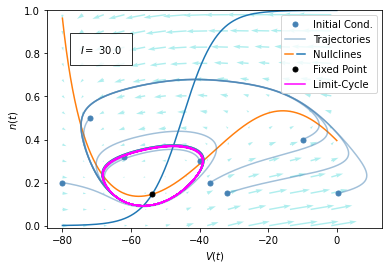

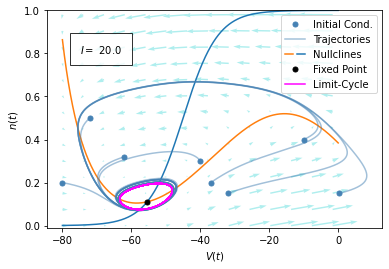

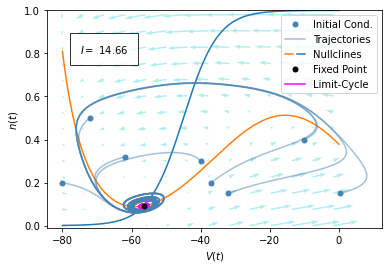

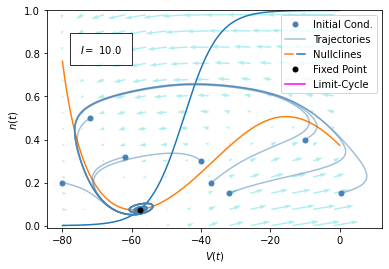

In [24]:
#@title Supercritical Andronov-Hopf bifurcation in the Phase Space
#@markdown - Emergence of a limit cycle after the bifurcation.
#@markdown - The stable fixed point loses stability to a limit cycle.
#@markdown - As the current increases so does the radius of the limit-cycle.

pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

Is = [10., 14.66, 20., 30.]

for I in Is[::-1]:

    current = np.ones(1+round(tempo / dt))* I

    n_V, n_n = get_nullclines(V, I, m_inf, pars)

    null1, = plt.plot(V, n_V, '-', color = 'tab:orange')
    null2, = plt.plot(V, n_n, '-', color = 'tab:blue')

    grid_ = np.linspace(-80., 0., 200)
    grid_1 = np.linspace(0., 1., 200)
    grid_v, grid_n = np.meshgrid(grid_, grid_1)
    dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)
    n_skip = 15
    plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
                dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
                angles='xy', scale_units='xy', scale=50., facecolor='paleturquoise')

    x_inits = [[-72, m_inf[0], .5], 
              [-62, m_inf[0], .32], 
              [-32., m_inf[0], .15], 
              [.32, m_inf[0], .15], 
              [-10., m_inf[0], .4], 
              [-40., m_inf[0], .3], 
              [-80., m_inf[0], .2], 
              [-37., m_inf[0], .2]]

    for x_init in x_inits:
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
        B, = plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)
        A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)
    
    if I == 30.:
        x_i = [-60, m_inf[0], .1]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo1, = plt.plot(q[:,0], q[:,2], color='magenta')
    
    elif I == 20.:
        x_i = [-60, m_inf[0], .17]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo1, = plt.plot(q[:,0], q[:,2], color='magenta')

    elif I == 14.66:
        x_i = [ -57,m_inf[0], .1]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo1, = plt.plot(q[:,0], q[:,2], color='magenta')

    else:
        pass

    inits = [[-79.9, 0.001]]
    for init in inits:
        fp = my_fp(pars, I, init[0], init[1])
        plt.plot(fp[0], fp[1], 'o', color='black', ms=5)

    plt.text(-75, 0.8, r'$I =$ {}'.format(I), #style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    
    plt.legend([A, B, (null1, null2), fps, ciclo1], ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point', 'Limit-Cycle'], numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    plt.ylabel(r'$n(t)$')
    plt.xlabel(r'$V(t)$')
    plt.ylim(top = 1., bottom = -0.01)
    plt.show()


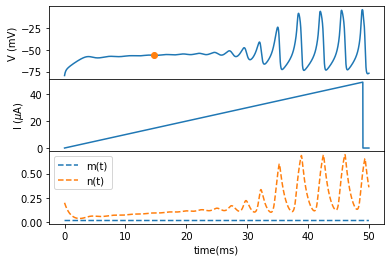

In [25]:
#@title Supercritical AH Example

#@markdown - Small oscillations before the bifurcation that aren't skipes.
#@markdown - The amplitude grows continuously with I.

# with plt.xkcd():
fig, (axis1,axis2, axis3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=0)

pars = resetting_parameters()

pars['tau'] = 1.
pars['V12_n'] = -45.
pars['El'] = -78.

dt = 0.01
tempo = 50

t_trans = 50
t = dt*np.arange(1+round(tempo/dt))
step = 0.01

current = np.zeros(1+round(tempo / dt)) 

for i in range(len(current[:-round(1/dt)])):
    current[i] +=  i*step


cond_init = [-80.]
n_init = [0.2] 
for V0 in cond_init:
  for n0 in n_init:
  
    m0 = .015
    

    init = [V0, m0, n0]

    q=simulate(InapIk_DEs, current, pars, dt, tempo, init)


# with plt.xkcd():
    axis1.plot(t, q[:,0],'-')
    axis1.plot(t[current >= 14.66][0], q[current >= 14.66,0][0],'o')
    axis1.set_ylabel('V (mV)')

    axis2.plot(t,current)
    axis2.set_ylabel(r'I ($\mu$A)')

    axis3.plot(t,q[:,1],'--', label = "m(t)")
    axis3.plot(t,q[:,2],'--', label = "n(t)")
    axis3.set_xlabel('time(ms)')
    axis3.legend()


plt.show()

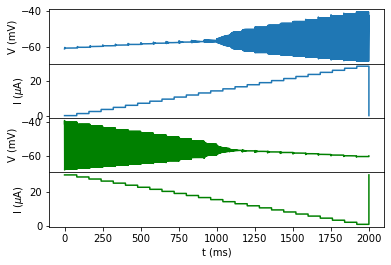

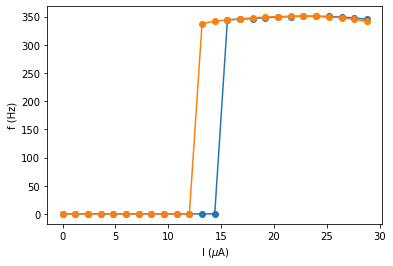

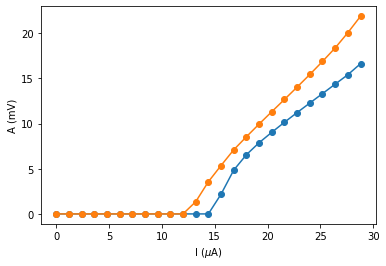

In [26]:
#@title Supercritical AH Frequency
#@markdown - Discontinuous and if I-Ib -> 0 => A -> 0

pars = resetting_parameters()

pars['tau'] = 1.
pars['V12_n'] = -45.
pars['El'] = -78.

cor = []
freq = []

# with plt.xkcd():
fig, ax = plt.subplots(4,1)
fig.subplots_adjust(hspace=0)

dt=0.01
tempo= 2000

st = 80
current_inicial = 0
current_final = 30
step = (current_final - current_inicial)/(tempo // st)

current1 = np.ones(1+round(tempo / dt)) * current_inicial

i = 0
for j in range(tempo//st):
    current1[round(i/dt):round((i+st)/dt)] += (i / st) * step
    i += st

current2 = np.zeros(1+round(tempo / dt))

current2[:] = current_final

i = 0
for j in range(tempo//st):
    current2[round(i/dt):round((i+st)/dt)] -= (i / st) * step
    cor.append((i / st) * step + current_inicial)
    i += st

V0 = -60.
m0 = 0.0
n0 = .1

init = [V0, m0, n0]

q1=simulate(InapIk_DEs, current1, pars, dt, tempo, init)
q2=simulate(InapIk_DEs, current2, pars, dt, tempo, init)

t=dt*np.arange(1+round(tempo/dt))

# with plt.xkcd():    
ax[0].plot(t[round(st/dt):],q1[round(st/dt):,0],'-')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t,current1)
ax[1].set_ylabel(r'I ($\mu$A)')

ax[2].plot(t[round(st/dt):],q2[round(st/dt):,0],'g-')
ax[2].set_ylabel('V (mV)')

ax[3].plot(t,current2, 'g-')
ax[3].set_ylabel(r'I ($\mu$A)')
ax[3].set_xlabel('t (ms)')

freq1 = []
freq2 = []
amp1 = []
amp2 = []

i = 0
for j in range(tempo//st):
    qsliced1 = q1[round(i/dt):round((i+st)/dt)]
    qsliced2 = q2[round(i/dt):round((i+st)/dt)]
    csl1 = (np.diff(np.sign(np.diff(qsliced1[:,0]))) < 0).nonzero()[0] + 1 
        # local max
    csl2 = (np.diff(np.sign(np.diff(qsliced2[:,0]))) < 0).nonzero()[0] + 1 
    t_peaks = []
    amp_peaks = []
    if len(csl1) > 2:
      for j in csl1:
        if qsliced1[j,0] > np.mean(qsliced1[:,0])+1:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced1[j,0] - np.mean(qsliced1[:,0]))
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq1.append(freq_aux)
        amp1.append(np.mean(amp_peaks))
      else:
        freq1.append(0)
        amp1.append(0)
    else:
      freq1.append(0)
      amp1.append(0)
    t_peaks = []
    amp_peaks = []
    if len(csl2) > 3:
      for j in csl2:
        if qsliced2[j,0] > np.mean(qsliced2[:,0])+1:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced2[j,0] - np.mean(qsliced1[:,0]))
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq2.append(freq_aux)
        amp2.append(np.abs(np.mean(amp_peaks)))
      else:
        freq2.append(0)
        amp2.append(0)
    else:
      freq2.append(0)
      amp2.append(0)
    i += st

plt.show()

plt.ylabel('f (Hz)')
plt.xlabel(r'I ($\mu$A)')
plt.plot(cor,freq1,'o-')
plt.plot(cor,freq2[::-1],'o-')
plt.show()
plt.plot(cor,amp1,'o-')
plt.plot(cor,amp2[::-1],'o-')
plt.ylabel('A (mV)')
plt.xlabel(r'I ($\mu$A)')
plt.show()

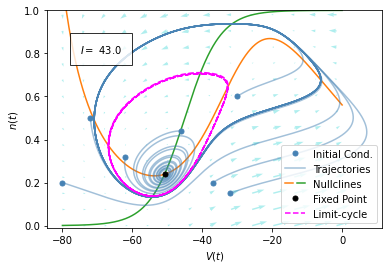

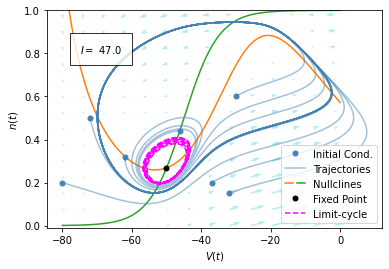

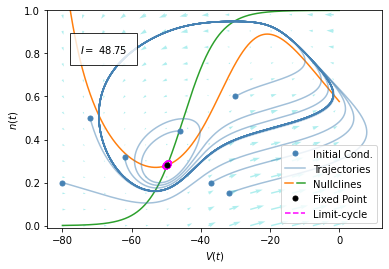

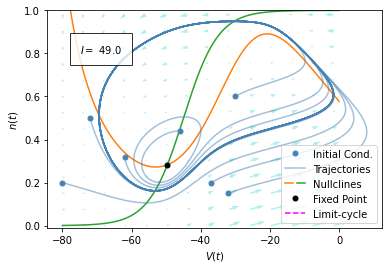

In [27]:
#@title Subcritical AH in the Phase Space
#@markdown - An unstable limit-cycle collides with a stable FP,
#@markdown  wich loses stability after the bifurcation.
#@markdown - The limit-cycle's radius decreases with the current. 

pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.
pars['gl'] = 1.
pars['gk'] = 4.
pars['gna'] = 4.
pars['V12_m'] = -30.
pars['k_m'] = 7

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

Is = [43., 47., 48.75, 49.]

for I in Is:
    current = np.ones(1+round(tempo / dt))* I

    n_V, n_n = get_nullclines(V, I, m_inf, pars)

    null1, = plt.plot(V, n_V, '-', color = 'tab:orange')
    null2, = plt.plot(V, n_n, '-', color = 'tab:green')

    grid_ = np.linspace(-80., 0., 200)
    grid_1 = np.linspace(0., 1., 200)
    grid_v, grid_n = np.meshgrid(grid_, grid_1)
    dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)
    n_skip = 15
    plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
                dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
                angles='xy', scale_units='xy', scale=50., facecolor='paleturquoise')

    x_inits = [[-72, m_inf[0], .5], 
              [-62, m_inf[0], .32], 
              [-32., m_inf[0], .15], 
              [-46, m_inf[0], .44], 
              [-30., m_inf[0], .6], 
              [-80., m_inf[0], .2], 
              [-37., m_inf[0], .2]]

    for x_init in x_inits:
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
        B, = plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)
        A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)
    
    if I == 43.:
        x_i = [-60, m_inf[0], .584607658]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo, = plt.plot(q[:,0], q[:,2], '--',color='magenta')
    
    elif I == 47.:
        x_i = [ -50,m_inf[0], .1999]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo, = plt.plot(q[:,0], q[:,2], '--',color='magenta')

    elif I == 48.75:
        x_i = [ -49,m_inf[0], .3]
        q = simulate(InapIk_DEs, current, pars, 0.1, tempo, x_i)
        ciclo, = plt.plot(q[:,0], q[:,2], '--',color='magenta')

    else:
        pass

    inits = [[-79.9, 0.001]]
    for init in inits:
        fp = my_fp(pars, I, init[0], init[1])
        fps, = plt.plot(fp[0], fp[1], 'o', color='black', ms=5)

    plt.text(-75, 0.8, r'$I =$ {}'.format(I), #style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    
    plt.legend([A, B, (null1, null2), fps, ciclo], \
                ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point', 'Limit-cycle'], \
                    numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})

    plt.ylabel(r'$n(t)$')
    plt.xlabel(r'$V(t)$')
    plt.ylim(top = 1., bottom = -0.01)
    plt.show()


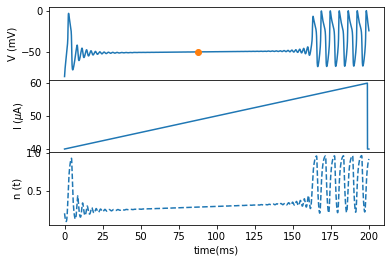

In [28]:
#@title Subcritical AH Example
#@markdown - Small oscillations that are not characterized as spikes.
#@markdown - The amplitude is non-zero at the bifurcation.

# with plt.xkcd():
fig, (axis1,axis2, axis3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=0)

pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.
pars['gl'] = 1.
pars['gk'] = 4.
pars['gna'] = 4.
pars['V12_m'] = -30.
pars['k_m'] = 7

dt = 0.01
tempo = 200

t_trans = 50
t = dt*np.arange(1+round(tempo/dt))
step = 0.001

current = np.ones(1+round(tempo / dt)) * 40

for i in range(len(current[:-round(1/dt)])):
    current[i] +=  i*step

# current = np.ones(1+round(tempo / dt)) * A
cond_init = [-80.]#np.arange(-65,-59, 2)
n_init = [0.2] #np.arange(0.0006, 0.0008, 0.00005)
for V0 in cond_init:
  for n0 in n_init:
  
    m0 = .015

    init = [V0, m0, n0]

    q=simulate(InapIk_DEs, current, pars, dt, tempo, init)


# with plt.xkcd():
    axis1.plot(t, q[:,0],'-')
    axis1.plot(t[current >= 48.75][0], q[current >= 48.75,0][0],'o')
    axis1.set_ylabel('V (mV)')

    axis2.plot(t,current)
    axis2.set_ylabel(r'I ($\mu$A)')

    axis3.set_ylabel('n (t)')
    axis3.plot(t,q[:,2],'--') 
    axis3.set_xlabel('time(ms)')

plt.show()

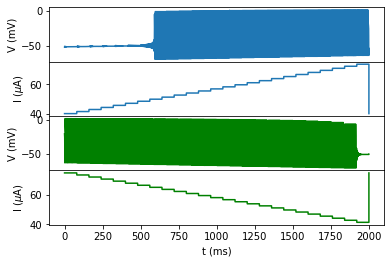

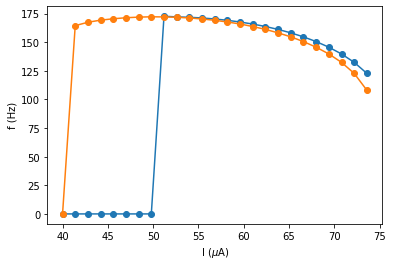

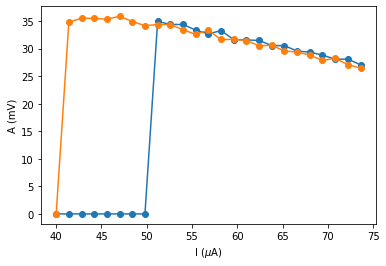

In [29]:
#@title Subcritical AH Frequency
#@markdown - Frequency and amplitude are discontinuous.

pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.
pars['gl'] = 1.
pars['gk'] = 4.
pars['gna'] = 4.
pars['V12_m'] = -30.
pars['k_m'] = 7

cor = []
freq = []

# with plt.xkcd():
fig, ax = plt.subplots(4,1)
fig.subplots_adjust(hspace=0)

dt=0.01
tempo= 2000

st = 80
current_inicial = 40
current_final = 75
step = (current_final - current_inicial)/(tempo // st)

current1 = np.ones(1+round(tempo / dt)) * current_inicial

i = 0
for j in range(tempo//st):
    current1[round(i/dt):round((i+st)/dt)] += (i / st) * step
    i += st

current2 = np.zeros(1+round(tempo / dt))

current2[:] = current_final

i = 0
for j in range(tempo//st):
    current2[round(i/dt):round((i+st)/dt)] -= (i / st) * step
    cor.append((i / st) * step + current_inicial)
    i += st

V0 = -80.
m0 = 0.0
n0 = .2

init = [V0, m0, n0]

q1=simulate(InapIk_DEs, current1, pars, dt, tempo, init)
q2=simulate(InapIk_DEs, current2, pars, dt, tempo, init)

t=dt*np.arange(1+round(tempo/dt))

# with plt.xkcd():    
ax[0].plot(t[round(st/dt):],q1[round(st/dt):,0],'-')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t,current1)
ax[1].set_ylabel(r'I ($\mu$A)')

ax[2].plot(t[round(st/dt):],q2[round(st/dt):,0],'g-')
ax[2].set_ylabel('V (mV)')

ax[3].plot(t,current2, 'g-')
ax[3].set_ylabel(r'I ($\mu$A)')
ax[3].set_xlabel('t (ms)')

freq1 = []
freq2 = []
amp1 = []
amp2 = []

i = 0
for j in range(tempo//st):
    qsliced1 = q1[round(i/dt):round((i+st)/dt)]
    qsliced2 = q2[round(i/dt):round((i+st)/dt)]
    csl1 = (np.diff(np.sign(np.diff(qsliced1[:,0]))) < 0).nonzero()[0] + 1 
        # local max
    csl2 = (np.diff(np.sign(np.diff(qsliced2[:,0]))) < 0).nonzero()[0] + 1 
    t_peaks = []
    amp_peaks = []
    if len(csl1) > 2:
      for j in csl1:
        if qsliced1[j,0] > np.mean(qsliced1[:,0])+20:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced1[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq1.append(freq_aux)
        amp1.append(np.mean(amp_peaks) - np.mean(qsliced1[:,0]))
      else:
        freq1.append(0)
        amp1.append(0)
    else:
      freq1.append(0)
      amp1.append(0)
    t_peaks = []
    amp_peaks = []
    if len(csl2) > 3:
      for j in csl2:
        if qsliced2[j,0] > np.mean(qsliced2[:,0])+20:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced2[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq2.append(freq_aux)
        amp2.append(np.abs(np.mean(amp_peaks) - np.mean(qsliced2[:,0])))
      else:
        freq2.append(0)
        amp2.append(0)
    else:
      freq2.append(0)
      amp2.append(0)
    i += st

plt.show()

plt.ylabel('f (Hz)')
plt.xlabel(r'I ($\mu$A)')
plt.plot(cor,freq1,'o-')
plt.plot(cor,freq2[::-1],'o-')
plt.show()
plt.plot(cor,amp1,'o-')
plt.plot(cor,amp2[::-1],'o-')
plt.ylabel('A (mV)')
plt.xlabel(r'I ($\mu$A)')
plt.show()

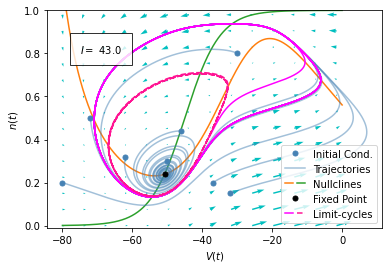

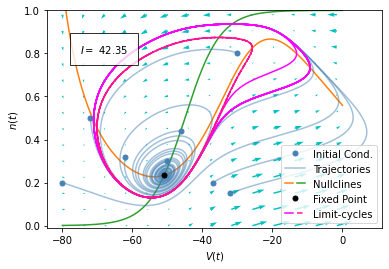

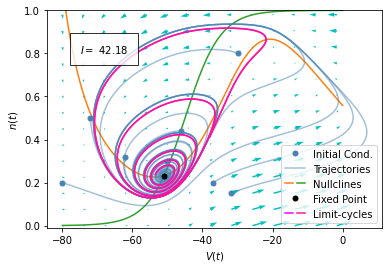

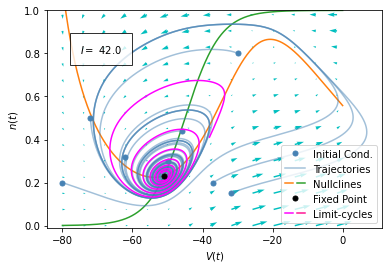

In [30]:
#@title Fold Limit Cicle Espaço de fases
#@markdown - Marca o aparecimento do ciclo-limite que colide na Hopf Sub.
#@markdown - Se formos diminuindo a current observamos uma colisão de dois ciclos-limite um estável e o outro instável.


pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.
pars['gl'] = 1.
pars['gk'] = 4.
pars['gna'] = 4.
pars['V12_m'] = -30.
pars['k_m'] = 7

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

Is = [42., 42.18, 42.35 ,43.] # + 0 * V
for I in Is[::-1]:
    current = np.ones(1+round(tempo / dt))* I

    n_V, n_n = get_nullclines(V, I, m_inf, pars)

    null1, = plt.plot(V, n_V, '-', color = 'tab:orange')
    null2, = plt.plot(V, n_n, '-', color = 'tab:green')

    grid_ = np.linspace(-80., 0., 200)
    grid_1 = np.linspace(0., 1., 200)
    grid_v, grid_n = np.meshgrid(grid_, grid_1)
    dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)
    n_skip = 15
    plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
                dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
                angles='xy', scale_units='xy', scale=50., facecolor='c')

    x_inits = [[-72, m_inf[0], .5], 
              [-62, m_inf[0], .32], 
              [-32., m_inf[0], .15], 
              [-46, m_inf[0], .44], 
              [-30., m_inf[0], .8], 
              [-50., m_inf[0], .3], 
              [-80., m_inf[0], .2], 
              [-37., m_inf[0], .2]]

    for x_init in x_inits:
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
        B, = plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)
        A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)

    x_i = [-38.025, m_inf[0], .41069]
    q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
    ciclo1, = plt.plot(q[:,0], q[:,2], color='magenta')

    if I == 43.:
        x_i = [-60, m_inf[0], .584607658]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo2, = plt.plot(q[:,0], q[:,2], '--',color='deeppink')
    elif I == 42.35:
        x_i = [-55, m_inf[0], .7983295097]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo2, = plt.plot(q[:,0], q[:,2], '--',color='deeppink')
    elif I == 42.18:
        x_i = [-38.025, m_inf[0], .41069]
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
        ciclo2, = plt.plot(q[:,0], q[:,2], '-',color='deeppink')
    
    inits = [[-79.9, 0.001]]
    for init in inits:
        fp = my_fp(pars, I, init[0], init[1])
        fps, = plt.plot(fp[0], fp[1], 'o', color='black', ms=5)

    plt.text(-75, 0.8, r'$I =$ {}'.format(I),
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    

    plt.legend([A, B, (null1, null2), fps, (ciclo1, ciclo2)], ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point','Limit-cycles'], numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    plt.ylabel(r'$n(t)$')
    plt.xlabel(r'$V(t)$')
    plt.ylim(top = 1., bottom = -0.01)
    plt.show()


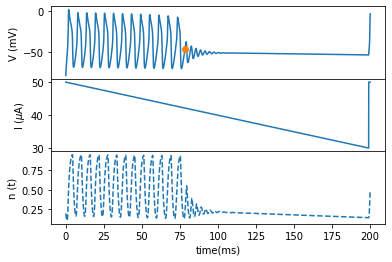

In [31]:
#@title Subcritical AH Example
#@markdown - Small oscillations that are not characterized as spikes.
#@markdown - The amplitude is non-zero at the bifurcation.

fig, (axis1,axis2, axis3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=0)

pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.
pars['gl'] = 1.
pars['gk'] = 4.
pars['gna'] = 4.
pars['V12_m'] = -30.
pars['k_m'] = 7

dt = 0.01
tempo = 200

t_trans = 50
t = dt*np.arange(1+round(tempo/dt))
step = 0.001

current = np.ones(1+round(tempo / dt)) * 50

for i in range(len(current[round(1/dt):])):
    current[i] -=  i*step


cond_init = [-80.]
n_init = [0.2] 
for V0 in cond_init:
  for n0 in n_init:
  
    m0 = .015

    init = [V0, m0, n0]

    q=simulate(InapIk_DEs, current, pars, dt, tempo, init)


# with plt.xkcd():
    axis1.plot(t, q[:,0],'-')
    axis1.plot(t[current <= 42.18][0], q[current <= 42.18,0][0],'o')
    axis1.set_ylabel('V (mV)')

    axis2.plot(t,current)
    axis2.set_ylabel(r'I ($\mu$A)')

    axis3.set_ylabel('n (t)')
    axis3.plot(t,q[:,2],'--') 
    axis3.set_xlabel('time(ms)')
    

plt.show()

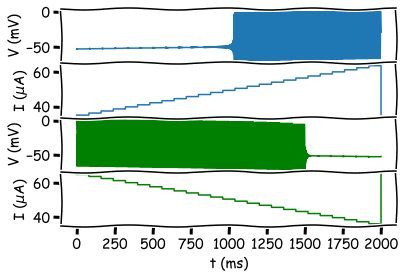

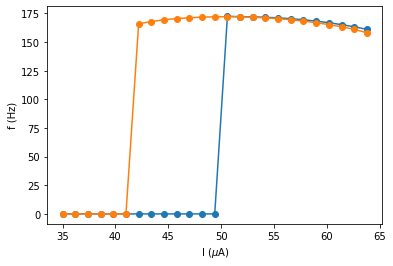

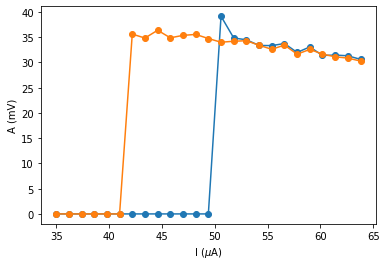

In [32]:
#@title Subcritical AH Frequency
#@markdown - Both frequency and amplitude are discontinuous.

pars = resetting_parameters()

pars['tau'] = 1.
pars['El'] = -78.
pars['V12_n'] = -45.
pars['gl'] = 1.
pars['gk'] = 4.
pars['gna'] = 4.
pars['V12_m'] = -30.
pars['k_m'] = 7

cor = []
freq = []

with plt.xkcd():
  fig, ax = plt.subplots(4,1)
  fig.subplots_adjust(hspace=0)

dt=0.01
tempo= 2000

st = 80
current_inicial = 35
current_final = 65
step = (current_final - current_inicial)/(tempo // st)

current1 = np.ones(1+round(tempo / dt)) * current_inicial

i = 0
for j in range(tempo//st):
    current1[round(i/dt):round((i+st)/dt)] += (i / st) * step
    i += st

current2 = np.zeros(1+round(tempo / dt))

current2[:] = current_final

i = 0
for j in range(tempo//st):
    current2[round(i/dt):round((i+st)/dt)] -= (i / st) * step
    cor.append((i / st) * step + current_inicial)
    i += st

V0 = -80.
m0 = 0.0
n0 = .2

init = [V0, m0, n0]

q1=simulate(InapIk_DEs, current1, pars, dt, tempo, init)
q2=simulate(InapIk_DEs, current2, pars, dt, tempo, init)

t=dt*np.arange(1+round(tempo/dt))

# with plt.xkcd():    
ax[0].plot(t[round(st/dt):],q1[round(st/dt):,0],'-')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t,current1)
ax[1].set_ylabel(r'I ($\mu$A)')

ax[2].plot(t[round(st/dt):],q2[round(st/dt):,0],'g-')
ax[2].set_ylabel('V (mV)')

ax[3].plot(t,current2, 'g-')
ax[3].set_ylabel(r'I ($\mu$A)')
ax[3].set_xlabel('t (ms)')

freq1 = []
freq2 = []
amp1 = []
amp2 = []

i = 0
for j in range(tempo//st):
    qsliced1 = q1[round(i/dt):round((i+st)/dt)]
    qsliced2 = q2[round(i/dt):round((i+st)/dt)]
    csl1 = (np.diff(np.sign(np.diff(qsliced1[:,0]))) < 0).nonzero()[0] + 1 
        # local max
    csl2 = (np.diff(np.sign(np.diff(qsliced2[:,0]))) < 0).nonzero()[0] + 1 
    t_peaks = []
    amp_peaks = []
    if len(csl1) > 2:
      for j in csl1:
        if qsliced1[j,0] > np.mean(qsliced1[:,0])+20:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced1[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq1.append(freq_aux)
        amp1.append(np.mean(amp_peaks) - np.mean(qsliced1[:,0]))
      else:
        freq1.append(0)
        amp1.append(0)
    else:
      freq1.append(0)
      amp1.append(0)
    t_peaks = []
    amp_peaks = []
    if len(csl2) > 3:
      for j in csl2:
        if qsliced2[j,0] > np.mean(qsliced2[:,0])+20:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced2[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq2.append(freq_aux)
        amp2.append(np.abs(np.mean(amp_peaks) - np.mean(qsliced2[:,0])))
      else:
        freq2.append(0)
        amp2.append(0)
    else:
      freq2.append(0)
      amp2.append(0)
    i += st

plt.show()

plt.ylabel('f (Hz)')
plt.xlabel(r'I ($\mu$A)')
plt.plot(cor,freq1,'o-')
plt.plot(cor,freq2[::-1],'o-')
plt.show()
plt.plot(cor,amp1,'o-')
plt.plot(cor,amp2[::-1],'o-')
plt.ylabel('A (mV)')
plt.xlabel(r'I ($\mu$A)')
plt.show()

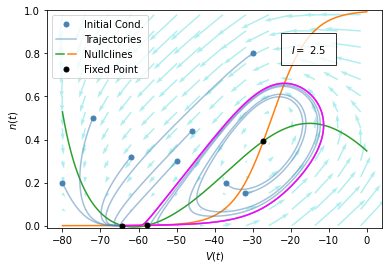

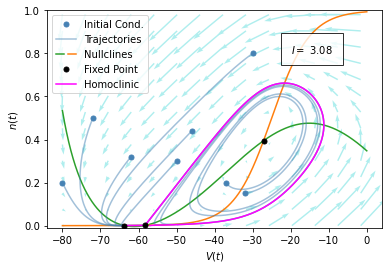

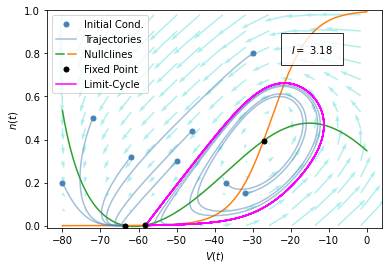

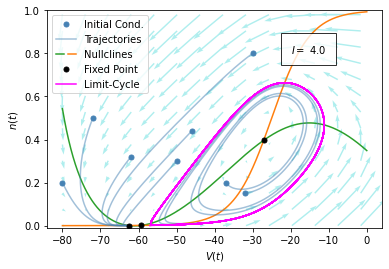

In [33]:
#@title Homoclinic Saddle-node in the Phase Space

pars = resetting_parameters()

pars['tau'] = .16

dt = 0.001
tempo = 20

V = np.arange(-80, 0, 0.01)
m_inf = 1/(1 + np.exp((pars['V12_m'] - V)/pars['k_m']))

Is = [2.5, 3.08, 3.18, 4.] 
for I in Is:
    current = np.ones(1+round(tempo / dt))* I

    n_V, n_n = get_nullclines(V, I, m_inf, pars)

    null1, = plt.plot(V, n_V, '-', color = 'tab:green')
    null2, = plt.plot(V, n_n, '-', color = 'tab:orange')

    grid_ = np.linspace(-80., 0., 200)
    grid_1 = np.linspace(0., 1., 200)
    grid_v, grid_n = np.meshgrid(grid_, grid_1)
    dVdt, dndt = InapIk_DE(grid_v, grid_n, pars, I)
    n_skip = 15
    plt.quiver(grid_v[::n_skip, ::n_skip], grid_n[::n_skip, ::n_skip],
                dVdt[::n_skip, ::n_skip], dndt[::n_skip, ::n_skip],
                angles='xy', scale_units='xy', scale=50., facecolor='paleturquoise')

    x_inits = [[-72, m_inf[0], .5], 
              [-62, m_inf[0], .32], 
              [-32., m_inf[0], .15], 
              [-46, m_inf[0], .44], 
              [-30., m_inf[0], .8], 
              [-50., m_inf[0], .3], 
              [-80., m_inf[0], .2], 
              [-37., m_inf[0], .2]]

    for x_init in x_inits:
        q = simulate(InapIk_DEs, current, pars, dt, tempo, x_init)
        B, = plt.plot(q[:,0], q[:,2], color='steelblue', alpha = 0.5)
        A, = plt.plot(x_init[0], x_init[2], 'o', color='steelblue', ms=5)

    x_i = [-57., m_inf[0], 0.0]
    q = simulate(InapIk_DEs, current, pars, dt, tempo, x_i)
    ciclo, = plt.plot(q[:,0], q[:,2], color='magenta')
    inits = [[-79.9, 0.001], [-57.9, 0.001], [-25.9, 0.5]]
    for init in inits:
        fp = my_fp(pars, I, init[0], init[1])
        fps, = plt.plot(fp[0], fp[1], 'o', color='black', ms=5)

    plt.text(-20, 0.8, r'$I =$ {}'.format(I),
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    if I < 3.08:
        plt.legend([A, B, (null1, null2), fps], ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point', 'Limit-Cycle'], numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    elif I == 3.08:
        plt.legend([A, B, (null1, null2), fps, ciclo], ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point', 'Homoclinic'], numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    else:
        plt.legend([A, B, (null1, null2), fps, ciclo], ['Initial Cond.', 'Trajectories', 'Nullclines', 'Fixed Point', 'Limit-Cycle'], numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)})
    plt.ylabel(r'$n(t)$')
    plt.xlabel(r'$V(t)$')
    plt.ylim(top = 1., bottom = -0.01)
    plt.show()


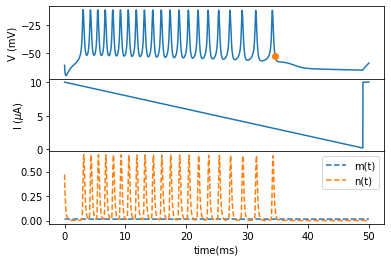

In [34]:
#@title Homoclinic Saddle-node example
#@markdown - Oscillations emerge at the bifurcation.
#@markdown - *tan t* structure between spikes.

# with plt.xkcd():
fig, (axis1,axis2, axis3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=0)

pars = resetting_parameters()

pars['tau'] = .16

dt = 0.01
tempo = 50

t_trans = 50
t = dt*np.arange(1+round(tempo/dt))
step = 0.002

current = np.ones(1+round(tempo / dt)) * 10

for i in range(len(current[:-round(1/dt)])):
    current[i] -=  i*step

cond_init = [-60.]
n_init = [0.5] 
for V0 in cond_init:
  for n0 in n_init:

    m0 = .015

    init = [V0, m0, n0]

    q=simulate(InapIk_DEs, current, pars, dt, tempo, init)


# with plt.xkcd():
    axis1.plot(t, q[:,0],'-')
    axis1.plot(t[current <= 3.08][0], q[current <= 3.08,0][0],'o')
    axis1.set_ylabel('V (mV)')

    axis2.plot(t,current)
    axis2.set_ylabel(r'I ($\mu$A)')

    axis3.plot(t,q[:,1],'--', label = "m(t)")
    axis3.plot(t,q[:,2],'--', label = "n(t)")
    axis3.set_xlabel('time(ms)')
    axis3.legend()

plt.show()

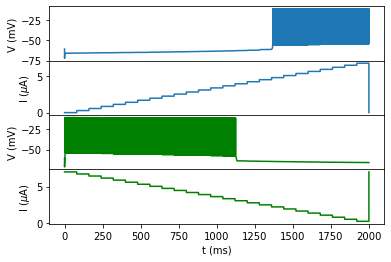

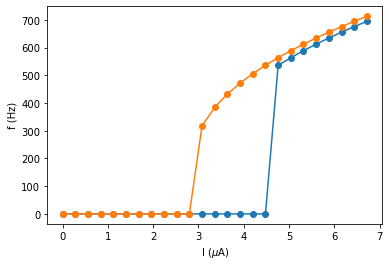

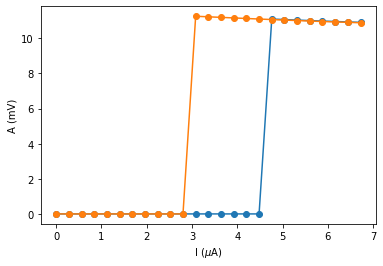

In [35]:
#@title Homoclinic Saddle-node Frequency
#@markdown - The frequency and amplitude are discontinuous and don't vanish at the bifurcation. 

pars = resetting_parameters()

pars['tau'] = .16

cor = []
freq = []

# with plt.xkcd():
fig, ax = plt.subplots(4,1)
fig.subplots_adjust(hspace=0)

dt=0.005
tempo= 2000

st = 80
current_inicial = 0
current_final = 7
step = (current_final - current_inicial)/(tempo // st)

current1 = np.ones(1+round(tempo / dt)) * current_inicial

i = 0
for j in range(tempo//st):
    current1[round(i/dt):round((i+st)/dt)] += (i / st) * step
    i += st

current2 = np.zeros(1+round(tempo / dt))

current2[:] = current_final

i = 0
for j in range(tempo//st):
    current2[round(i/dt):round((i+st)/dt)] -= (i / st) * step
    cor.append((i / st) * step + current_inicial)
    i += st

V0 = -60.
m0 = 0.0
n0 = .5

init = [V0, m0, n0]

q1=simulate(InapIk_DEs, current1, pars, dt, tempo, init)
q2=simulate(InapIk_DEs, current2, pars, dt, tempo, init)

t=dt*np.arange(1+round(tempo/dt))

# with plt.xkcd():    
ax[0].plot(t,q1[:,0],'-')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t,current1)
ax[1].set_ylabel(r'I ($\mu$A)')

ax[2].plot(t,q2[:,0],'g-')
ax[2].set_ylabel('V (mV)')

ax[3].plot(t,current2, 'g-')
ax[3].set_ylabel(r'I ($\mu$A)')
ax[3].set_xlabel('t (ms)')

freq1 = []
freq2 = []
amp1 = []
amp2 = []

i = 0
for j in range(tempo//st):
    qsliced1 = q1[round(i/dt):round((i+st)/dt)]
    qsliced2 = q2[round(i/dt):round((i+st)/dt)]
    csl1 = (np.diff(np.sign(np.diff(qsliced1[:,0]))) < 0).nonzero()[0] + 1 
        # local max
    csl2 = (np.diff(np.sign(np.diff(qsliced2[:,0]))) < 0).nonzero()[0] + 1 
    t_peaks = []
    amp_peaks = []
    if len(csl1) > 2:
      for j in csl1:
        if qsliced1[j,0] > -50.0:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced1[j,0])
      if (len(t_peaks) > 2):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq1.append(freq_aux)
        amp1.append(np.abs(np.mean(amp_peaks)))
      else:
        freq1.append(0)
        amp1.append(0)
    else:
      freq1.append(0)
      amp1.append(0)
    t_peaks = []
    amp_peaks = []
    if len(csl2) > 3:
      for j in csl2:
        if qsliced2[j,0] > -50.0:
          t_peaks.append(t[j])
          amp_peaks.append(qsliced2[j,0])
      if (len(t_peaks) > 3):
        isi = np.diff(t_peaks) / 1000
        freq_aux = 1 / np.mean(isi)
        freq2.append(freq_aux)
        amp2.append(np.abs(np.mean(amp_peaks)))
      else:
        freq2.append(0)
        amp2.append(0)
    else:
      freq2.append(0)
      amp2.append(0)
    i += st

plt.show()

plt.ylabel('f (Hz)')
plt.xlabel(r'I ($\mu$A)')
plt.plot(cor,freq1,'o-')
plt.plot(cor,freq2[::-1],'o-')
plt.show()
plt.plot(cor,amp1,'o-')
plt.plot(cor,amp2[::-1],'o-')
plt.ylabel('A (mV)')
plt.xlabel(r'I ($\mu$A)')
plt.show()